In [1634]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx 
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
from pathlib import Path
import numpy as np

In [1635]:
df = pd.read_json('../data/data.json')

In [1636]:
df_shape = df.shape
print(f'Rows and columns in one JSON file is {df_shape}')

Rows and columns in one JSON file is (166, 6)


In [1637]:
df_rows = df.head(10)
print(f'First 10 columns in one JSON file is {df_rows}')

First 10 columns in one JSON file is                    name artist  year gender   likes  bought
0                 Queen  Queen  1973   Rock  3258.0    True
1              Queen II  Queen  1974   Rock  4017.0    True
2    Sheer Heart Attack  Queen  1974   Rock  2427.0   False
3  A Night at the Opera  Queen  1975   Rock  2712.0   False
4     News of the World  Queen  1977   Rock  3488.0    True
5                  Jazz  Queen  1978   Rock  1377.0   False
6              The Game  Queen  1980   Rock  6636.0    True
7             Hot Space  Queen  1982   Rock  1762.0   False
8             The Works  Queen  1984   Rock  5530.0   False
9       A Kind of Magic  Queen  1986   Rock  3328.0    True


In [1638]:
print(f'The column names are :')
print('#########')
for col in df.columns:
    print(col)

The column names are :
#########
name
artist
year
gender
likes
bought


In [1639]:
cols = df.filter(regex='nam').columns

print(cols)

Index(['name'], dtype='object')


In [1640]:
print("The #rows and #columns are ", df.shape[0] , " and ", df.shape[1])
print("The years in this dataset are: ", df.year.unique())
print("The artists covered in this dataset are: ", list(df.artist.unique()))
print("The genders covered are: ", list(df.gender.unique()))

The #rows and #columns are  166  and  6
The years in this dataset are:  [1973 1974 1975 1977 1978 1980 1982 1984 1986 1989 1991 1995 1993 1963
 1964 1965 1966 1967 1968 1970 1976 1979 1981 2021 2012 2015 2017 2018
 1999 2001 2003 2006 2009 2022 1969 1971 1972 1983 1987 1997 2002 2013
 2016 1996 2000 2010 2014 2004 2005 2008 2019 2020 2024 1956 1957 1960
 1961 1962 1985]
The artists covered in this dataset are:  ['Queen', 'Nirvana', 'The Beatles', 'ABBA', 'Imagine Dragons', 'MUSE', 'Rosalía', 'David Bowie', 'Spice Girls', 'Michael Jackson', 'Archive', 'Daft Punk', 'Taylor Swift', 'Elvis Presley', 'Supertramp']
The genders covered are:  ['Rock', 'Pop', 'Pop Rock', 'Alternative Rock', 'Flamenco', 'Electronic', 'Rock and Roll', 'Progressive Pop']


In [1641]:
counts = pd.DataFrame({'Count':df.gender.value_counts()})
counts

,Count
gender,
Rock,64
Pop,36
Rock and Roll,23
Electronic,16
Progressive Pop,11
Alternative Rock,9
Pop Rock,4
Flamenco,3


In [1642]:
counts.sort_values(by=['gender'],ascending=True).head(15)

,Count
gender,
Alternative Rock,9
Electronic,16
Flamenco,3
Pop,36
Pop Rock,4
Progressive Pop,11
Rock,64
Rock and Roll,23


In [1643]:
df.rename(columns={'bought':'is_bought'}, inplace=True)

In [1644]:
df.isnull().sum(axis=0)

name         0
artist       0
year         0
gender       0
likes        4
is_bought    0
dtype: int64

In [1645]:
df = df[~df.likes.isnull()]
df.isnull().sum(axis = 0)

name         0
artist       0
year         0
gender       0
likes        0
is_bought    0
dtype: int64

<Axes: xlabel='is_bought', ylabel='count'>

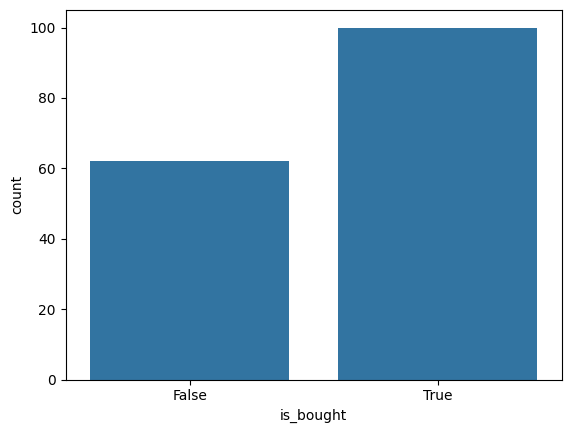

In [1646]:
sns.countplot(x = 'is_bought', data=df)

In [1647]:
data_orig = df.copy()
data = df[['is_bought', 'likes','name', 'artist', 'year', 'gender']]
categorical_columns  = ['name', 'artist', 'year','gender']
for c in categorical_columns:
    data[c] = data[c].astype('category')
    
print(f'The column names are :')
print('#########')
for col in data.columns:
    print(col)

print(f'The column types are :')
print('#########')
for col in data.dtypes:
    print(col)

The column names are :
#########
is_bought
likes
name
artist
year
gender
The column types are :
#########
bool
float64
category
category
category
category


In [1648]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
data_dummies = data_dummies.replace({True: 1, False: 0})
not_categorical_columns  = ['is_bought','likes']
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

C:\Users\j.pardo\AppData\Local\Temp\ipykernel_6512\16605558.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_dummies = data_dummies.replace({True: 1, False: 0})


In [1649]:
print("The #rows and #columns are ", data.shape[0] , " and ", data.shape[1])

The #rows and #columns are  162  and  238


In [1650]:
print(f'The column names are :')
print('#########')
for col in data.columns:
    print(col)

The column names are :
#########
is_bought
likes
name_...Famous Last Words... 
name_1989
name_A Hard Day's Night
name_A Kind of Magic
name_A Night at the Opera
name_ABBA
name_Abbey Road
name_Absolution
name_Aladdin Sane
name_Arrival
name_Axiom
name_Bad
name_Beatles '65
name_Beatles VI
name_Beatles for Sale
name_Ben
name_Black Holes and Revelations
name_Black Tie White Noise
name_Bleach
name_Blood on the Dance Floor: History in the Mix
name_Breakfast in America
name_Brother Where You Bound
name_Call to Arms and Angels
name_Controlling Crowds
name_Controlling Crowds – Part IV
name_Crime of the Century 
name_Crisis? What Crisis?
name_Dangerous
name_Diamond Dogs
name_Discovery
name_Drones
name_Earthlinge
name_El mal querer
name_Elvis
name_Elvis Is Back!
name_Elvis Now
name_Elvis Presley
name_Elvis for Everyone!
name_Elvis sings The Wonderful World of Christmas
name_Elvis' Christmas Album
name_Even in the Quietest Moments...
name_Evermore
name_Fearless
name_Folklore
name_Forever
name_Foreve

In [1651]:
data.rename(columns = {'is_bought':'target'}, inplace=True )

In [1652]:
features = ['likes']

In [1653]:
X = data[features]
Y = data['target']

Config

In [1654]:
batch_size = 10
num_of_epochs = 1000
learning_rate=0.01
weight_decay=0.0001
test_size = 0.33
random_state=42

Train / Test Data

In [1655]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

Logger

In [1656]:
class Logger:
    def __init__(self)-> None:
        self.writer = SummaryWriter()

    def __flush__(self) -> None:
        self.writer.flush

    def __del__(self) -> None:
        self.writer.flush()
        self.writer.close()

Tensors

In [1657]:
class Data(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray) -> None:  
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32))
    self.len = self.X.shape[0]

  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]
  
  def __len__(self) -> int:
    return self.len

Loader

In [1658]:
class Loader:
    def __init__(self, train:Data, test:Data) -> None:
        self.train = DataLoader(train, batch_size=batch_size, shuffle=True)
        self.test = DataLoader(test, batch_size=batch_size, shuffle=True)

Train / Test Data Loader

In [1659]:
traindata = Data(X_train.values, y_train.values)
testdata = Data(X_test.values, y_test.values)

# create Loader to read the data within batch sizes and put into memory. 
loader = Loader(traindata, testdata)

Model Architecture:

In [1660]:
class LinearRegression(nn.Module): # all the dependencies from torch will be given to this class [parent class] # nn.Module contains all the building block of neural networks:
  def __init__(self,input_dim):
    super(LinearRegression,self).__init__()   # building connection with parent and child classes
    self.fc1=nn.Linear(input_dim,10)          # hidden layer 1
    self.fc2=nn.Linear(10,5)                  # hidden layer 2
    self.fc3=nn.Linear(5,3)                   # hidden layer 3
    self.fc4=nn.Linear(3,1)                   # last layer

  def forward(self,d):
    out=torch.relu(self.fc1(d))              # input * weights + bias for layer 1
    out=torch.relu(self.fc2(out))            # input * weights + bias for layer 2
    out=torch.relu(self.fc3(out))            # input * weights + bias for layer 3
    out=self.fc4(out)                        # input * weights + bias for last layer
    return out                               # final outcome

Model setup:

In [1661]:
input_dim = X_train.shape[1]
torch.manual_seed(42)  # to make initilized weights stable:
model = LinearRegression(input_dim)

Loss & Optimizer

In [1662]:
# Define the loss function with Mean Squared Error loss and an optimizer with Adam optimizer
loss = nn.MSELoss()
optimizers=optim.Adam(params=model.parameters(),lr=learning_rate, weight_decay = weight_decay)

Using TensorBoard

In [1663]:
logger = Logger()

Model Load

In [1664]:
def load()-> None:
    # let's create a dummy input tuple  
    dummy_input = (1)

    # we can load the saved model and do the inference again 
    load_model=LinearRegression(dummy_input)
    load_model.load_state_dict(torch.load('saved/Network.pth'))

Model Save

In [1665]:
# Function to save the model 
def save() -> None:
    filename=Path('saved')
    filename.mkdir(parents=True,exist_ok=True)    
    model_name='Network.pth' 

    saving_path=filename/model_name   
    torch.save(obj=model.state_dict(),f=saving_path)

Model Export

In [1666]:
#Function to Convert to ONNX 
def export(): 

    # set the model to inference mode 
    model.eval() 

    # let's create a dummy input tensor  
    dummy_input = torch.randn(1)  

    # export the model   
    torch.onnx.export(model,         # model being run 
         dummy_input,       # model input (or a tuple for multiple inputs) 
         "saved/Network.onnx",       # where to save the model  
         export_params=True,  # store the trained parameter weights inside the model file 
         opset_version=11,    # the ONNX version to export the model to 
         do_constant_folding=True,  # whether to execute constant folding for optimization 
         input_names = ['input'],   # the model's input names 
         output_names = ['output'], # the model's output names 
         dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes 
                                'output' : {0 : 'batch_size'}}) 
    print(" ") 
    print('Model has been converted to ONNX') 

Model Inspect

In [1667]:
#Function to Inspect the model on TensorBoard 
def inspect() -> None:
    
    # let's create a dummy input tensor  
    dummy_input = torch.randn(1)  

    # we can inspect the model using TensorBoard
    logger.writer.add_graph(model, dummy_input)

Model Test

In [1668]:
# Function to test the model with the test dataset and print the accuracy for the test records
def test(epoch) -> float | any:
    
    model.eval()
    accuracy = 0.0
    total = 0.0  
    batch_loss = 0.0  
    
    with torch.no_grad():
        for b, data in enumerate(loader.test, 0):        
           
            # get the inputs
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))

            # run the model on the test set to predict labels
            
            outputs = model(inputs)

            loss_value = loss(outputs, targets)

            # let's print statistics for every batch
            batch_loss += loss_value.item()     

            if b == data.__len__():         

                # log the batch loss
                logger.writer.add_scalar('test/batch/loss',batch_loss / data.__len__(),epoch * len(loader.train) + b)             

                # zero the loss
                batch_loss = 0.0      

            global_step = epoch * len(loader.test) + b
            
            logger.writer.add_scalar('test/loss', loss_value.item(), global_step=global_step)
            logger.writer.add_scalar('test/confidence', torch.mean(torch.max(torch.softmax(outputs, dim=1), dim=1)[0]).item(), global_step=global_step)

            logger.writer.add_histogram('test/outputs', torch.max(outputs, dim=1)[0], global_step=global_step)
            logger.writer.add_histogram('test/confidences', torch.max(torch.softmax(outputs, dim=1), dim=1)[0], global_step=global_step)
            
            
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            accuracy += (predicted == targets).sum().item()
    
    # compute the accuracy over all test records
    accuracy = (100 * accuracy / total)
    return(accuracy)

Model Train

In [1669]:
# Training Function 

# The training routine is held simple, setting up inputs and targets,
# zeroing the optimizer's gradients and finally doing a forward and backward
# to update the parameters.
def train(num_of_epochs: float = 1000) -> None:

  best_accuracy = 0.0
 
  # define your execution device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  logger.writer.add_text('config/model', model.__class__.__name__)
  logger.writer.add_text('config/optimizer', optimizers.__class__.__name__)
  logger.writer.add_text('config/device', str(device)) 
 
  model.to(device)

  # loop over the dataset multiple times
  for epoch in range(num_of_epochs):

    batch_loss = 0.0     
   
    for b, data in enumerate(loader.train, 0):  

      # get the inputs
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      targets = targets.reshape((targets.shape[0], 1))

      # zero the parameter gradients
      optimizers.zero_grad()

      # predict classes using records from the training set
      outputs=model(inputs) 

      # compute the loss based on model output and real targets
      loss_value=loss(outputs, targets)    
     
      # backpropagate the loss
      loss_value.backward()  

      # adjust parameters based on the calculated gradients
      optimizers.step() 

      global_step = epoch * len(loader.train) + b
      logger.writer.add_scalar('train/loss', loss_value.item(), global_step=global_step)
      logger.writer.add_scalar('train/confidence', torch.mean(torch.max(torch.softmax(outputs, dim=1), dim=1)[0]).item(), global_step=global_step)

      logger.writer.add_histogram('train/outputs', torch.max(outputs, dim=1)[0], global_step=global_step)
      logger.writer.add_histogram('train/confidences', torch.max(torch.softmax(outputs, dim=1), dim=1)[0], global_step=global_step)

      # let's print statistics for every batch
      batch_loss += loss_value.item()     
     
      if b == data.__len__():         

        # log the batch loss
        logger.writer.add_scalar('train/batch/loss',batch_loss / data.__len__(),epoch * len(loader.train) + b)             

        # zero the loss
        batch_loss = 0.0      
     

    # compute and print the average accuracy fo this epoch when tested over all test records
    accuracy = test(epoch)
    print('For epoch', epoch,'the test accuracy over the whole test set is %d %%' % (accuracy))
      
    # we want to save the model if the accuracy is the best
    if accuracy > best_accuracy:
      save()     
      best_accuracy = accuracy  

  logger.__flush__()

  print('Finished Training')

In [1670]:
train()

For epoch 0 the test accuracy over the whole test set is 385 %
For epoch 1 the test accuracy over the whole test set is 396 %
For epoch 2 the test accuracy over the whole test set is 385 %
For epoch 3 the test accuracy over the whole test set is 374 %
For epoch 4 the test accuracy over the whole test set is 396 %


For epoch 5 the test accuracy over the whole test set is 385 %
For epoch 6 the test accuracy over the whole test set is 385 %
For epoch 7 the test accuracy over the whole test set is 374 %
For epoch 8 the test accuracy over the whole test set is 385 %
For epoch 9 the test accuracy over the whole test set is 385 %
For epoch 10 the test accuracy over the whole test set is 374 %
For epoch 11 the test accuracy over the whole test set is 374 %
For epoch 12 the test accuracy over the whole test set is 374 %
For epoch 13 the test accuracy over the whole test set is 374 %
For epoch 14 the test accuracy over the whole test set is 407 %
For epoch 15 the test accuracy over the whole test set is 385 %
For epoch 16 the test accuracy over the whole test set is 407 %
For epoch 17 the test accuracy over the whole test set is 396 %
For epoch 18 the test accuracy over the whole test set is 385 %
For epoch 19 the test accuracy over the whole test set is 396 %
For epoch 20 the test accuracy over the whole

In [1671]:
load()

In [1672]:
export()

 
Model has been converted to ONNX


In [1673]:
inspect()

In [1674]:
del logger